# Visualization
In this notebook, we're going to explore what the model we have trained actually learned.
This involves some of the following things:
* **Verify that we actually get better while learning**
* **Look at the motifs we learn**
* What does the hidden layer tell us about the model

In [1]:
# some always important inputs
import sys
import os
import random
import time
import numpy as np
import cPickle
#import PIL
from corebio.seq import Alphabet
from weblogolib import LogoData, LogoFormat, LogoOptions, classic, png_print_formatter, png_formatter
from cStringIO import StringIO
np.set_printoptions(precision=2, suppress=True)

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

ERROR (theano.sandbox.cuda): Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
ERROR:theano.sandbox.cuda:Failed to compile cuda_ndarray.cu: libcublas.so.7.0: cannot open shared object file: No such file or directory
WARNING (theano.sandbox.cuda): CUDA is installed, but device gpu is not available  (error: cuda unavailable)


Couldn't import dot_parser, loading of dot files will not be possible.


## Read in the data and a previously trained model
This part of the notebook trains a convolutional RBM on the DHS data. This may take a lot of time but only once we trained it, will it be possible to do the visualization of what the model learnt.

In [28]:
# read in the model
date_string = '2016_02_18_16_09'
modelDir = '../../training/' + date_string
learner = CRBM(file_name = modelDir + '/model.pkl')

In [29]:
print learner.motifs.get_value()[0]

[[[-0.21  0.66 -0.15  1.01  0.75 -0.94  0.79  1.53  0.08  0.4  -1.33]
  [-0.03 -0.02 -0.73 -0.26 -0.88 -0.78  0.35  0.34 -0.91  0.93  0.25]
  [ 0.48  0.86 -0.43  0.66 -0.14 -1.63  1.36  2.14 -0.12 -0.28 -0.86]
  [-1.04  1.59 -1.1   1.15 -0.02 -1.13 -0.44  0.78 -1.01 -0.8  -0.09]]]


### Some basic funcions to get motifs from the matrices

In [30]:

def getLetterToInt (num):
    if num == 0:
        return 'A'
    elif num == 1:
        return 'C'
    elif num == 2:
        return 'G'
    elif num == 3:
        return 'T'
    else:
        print 'ERROR: Num ' + str(num) + " not a valid char in DNA alphabet"
        return -1


def softmax(x):
    x_exp = np.exp(x)
    y = np.zeros(x.shape)
    for i in range(x.shape[1]):
        y[:,i] = x_exp[:,i] / np.sum(x_exp[:,i])
    return y

def createWeblogo(pwm, c):
    alph = Alphabet('ACGT')
    weblogoData = LogoData.from_counts(alph, pwm.T)#, c)#, learner.c.get_value().reshape(-1))
    weblogoOptions = LogoOptions(color_scheme=classic)
    weblogoFormat = LogoFormat(weblogoData, weblogoOptions)
    x = png_formatter(weblogoData, weblogoFormat)
    fake_file = StringIO(x)
    return plt.imread(fake_file)

def getLogoListFrom4DMatrix(matrix, c):
    images = []
    for motifNum in range(matrix.shape[0]):
        probabilityMatrix = softmax(matrix[motifNum,0])
        m = createWeblogo(probabilityMatrix, c)
        images.append(m)
    return images

import math
bestSplit = lambda x: (round(math.sqrt(x)), math.ceil(x / round(math.sqrt(x))))

def getObserverIndex(string):
    count = 0
    for obs in learner.observers:
        if string.lower() in obs.name.lower():
            print "Chose observer: " + obs.name
            return count
        count += 1

def plotMotifHitsForFrame (frameNr):
    plt.subplot(2,1,1)
    # initially, score is matrix of K x 1 x N_h
    obsIdx = getObserverIndex("hit")
    scores = learner.observers[obsIdx].scores[frameNr].sum(axis=0) # mean over K (1 x N_h)
    scores = scores.reshape(-1) # N_h array
    plt.bar(range(0,scores.shape[0]), scores)
    
    plt.subplot(2,1,2)
    scores = scores.reshape(-1)
    plt.hist(scores,facecolor='green',alpha=0.75)
    plt.xlabel('Activation per nucleotide')
    plt.ylabel('Proportion')
    plt.grid(True)
    plt.savefig(modelDir + '/motifHits_frame_' + str(frameNr) + '.png')
    plt.show()

In [31]:
learner.printHyperParams()
print len(learner.observers[getObserverIndex("motif")].scores)

{'batch_size': 300,
 'biases_to_zero': False,
 'cd_k': 2,
 'doublestranded': False,
 'epochs': 500,
 'learning_rate': 0.01,
 'momentum': 0.9,
 'motif_length': 11,
 'number_of_motifs': 40,
 'pooling_factor': 5,
 'rho': 0.001,
 'sparsity': 0.3,
 'verbose': False}
Chose observer: Motif Hit Observer
6


In [32]:
print learner.motifs.get_value()

[[[[-0.21  0.66 -0.15 ...,  0.08  0.4  -1.33]
   [-0.03 -0.02 -0.73 ..., -0.91  0.93  0.25]
   [ 0.48  0.86 -0.43 ..., -0.12 -0.28 -0.86]
   [-1.04  1.59 -1.1  ..., -1.01 -0.8  -0.09]]]


 [[[ 1.07  0.87  0.65 ...,  1.1  -0.13 -1.9 ]
   [-0.11  0.48  1.42 ...,  0.81 -0.   -0.6 ]
   [ 0.42 -0.02 -1.23 ...,  0.6  -0.74 -1.05]
   [ 1.68 -0.52 -1.19 ...,  1.49 -0.2  -1.68]]]


 [[[-0.8  -1.81 -1.42 ...,  1.16  0.13  0.55]
   [-1.33 -0.79 -2.27 ...,  0.73  0.17  0.69]
   [-0.42 -1.03  0.94 ..., -0.12  0.08  1.55]
   [ 0.95  0.03 -0.1  ...,  0.75  0.46  0.12]]]


 ..., 
 [[[ 0.71 -0.73  0.89 ..., -0.35  1.05  0.36]
   [-0.7  -1.4   0.01 ..., -0.02  1.03  0.65]
   [-1.33  1.29  0.46 ..., -1.38 -0.93  0.12]
   [-0.68 -1.03  1.   ..., -0.72  1.19  2.11]]]


 [[[ 0.22 -0.18  0.29 ...,  0.35 -0.88  0.88]
   [-0.87 -0.09  0.35 ..., -0.06 -1.13  1.33]
   [-0.3  -0.29  0.34 ...,  0.45  0.58 -0.35]
   [ 0.93  0.5  -0.58 ..., -0.07  0.16  1.48]]]


 [[[ 0.04  1.04  0.26 ...,  2.12 -0.48  0.02]
   [-1.

## Visualize motif hits

Chose observer: Motif Hit Observer


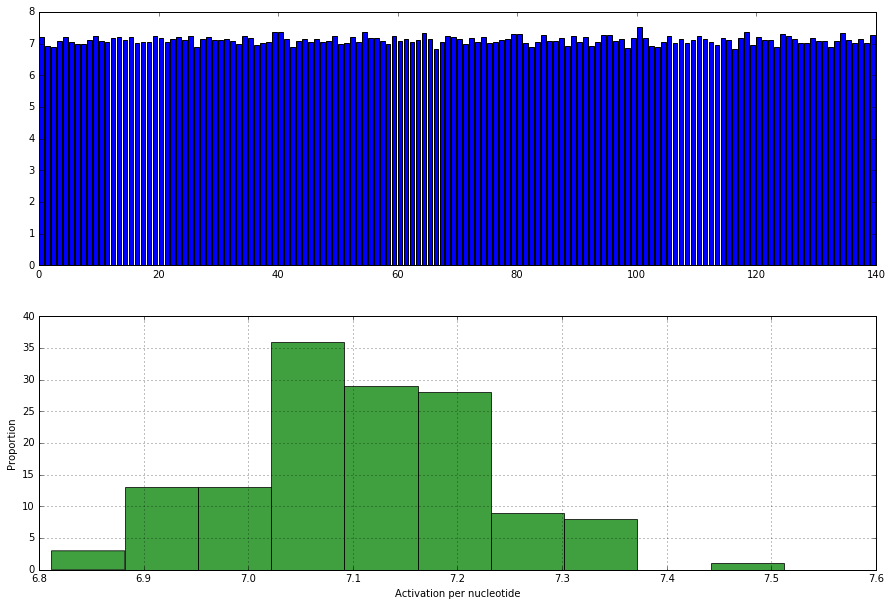

Chose observer: Motif Hit Observer


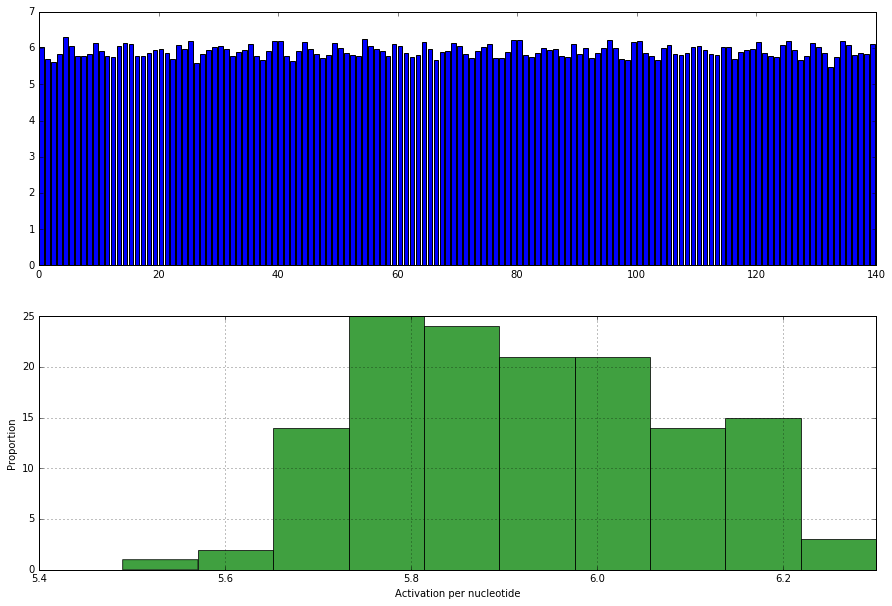

Chose observer: Motif Hit Observer


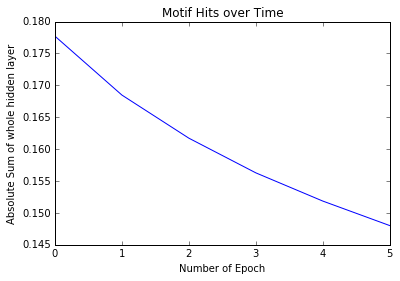

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(15,10))
plotMotifHitsForFrame(0)
fig = plt.figure(figsize=(15,10))
plotMotifHitsForFrame(len(learner.observers[0].scores)-1)

idx = getObserverIndex("hit")
l = []
for i in range(len(learner.observers[idx].scores)):
    l.append(np.abs(learner.observers[idx].scores[i]).mean())

plt.title('Motif Hits over Time')
plt.ylabel('Absolute Sum of whole hidden layer')
plt.xlabel('Number of Epoch')
plt.plot(l)
plt.savefig(modelDir + '/motifHitsOverTime.png', dpi=400)

## Plot the development of the weights over time

Chose observer: Parameter Observer


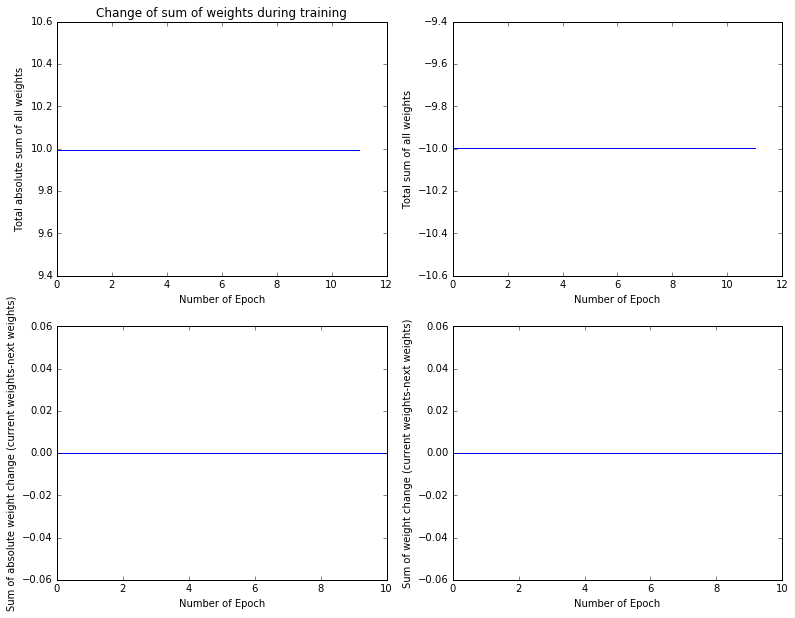

In [14]:
%matplotlib inline

listOfAbsSums = []
listOfSums = []

idx = getObserverIndex("parameter")
obsRef = learner.observers[idx]
for i in range(len(obsRef.scores)):
    listOfAbsSums.append(np.abs(obsRef.scores[i][0]).mean())

for i in range(len(learner.observers[idx].scores)):
    listOfSums.append(learner.observers[idx].scores[i][0].mean())
    
fig = plt.figure(figsize=(13,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Number of Epoch')
ax1.set_title('Change of sum of weights during training')
ax1.set_ylabel('Total absolute sum of all weights')
ax1.plot(listOfAbsSums)
#ax1.savefig(modelDir + '/weightDevelopmentAbs.png', dpi=600)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Number of Epoch')
ax2.set_ylabel('Total sum of all weights')
ax2.plot(listOfSums)

listOfDiffs = []
for i in range(len(obsRef.scores)-1):
    listOfDiffs.append((obsRef.scores[i+1][0]-obsRef.scores[i][0]).mean())

listOfDiffsAbs = []
for i in range(len(learner.observers[idx].scores)-1):
    listOfDiffsAbs.append(np.abs(obsRef.scores[i+1][0]-obsRef.scores[i][0]).mean())

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('Number of Epoch')
ax3.set_ylabel('Sum of absolute weight change (current weights-next weights)')
ax3.plot(listOfDiffsAbs)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Number of Epoch')
ax4.set_ylabel('Sum of weight change (current weights-next weights)')
ax4.plot(listOfDiffs)

fig.savefig(modelDir + '/weightDevelopment.png', dpi=600)

## Plot the other parameters (bias and c)

Chose observer: Parameter Observer


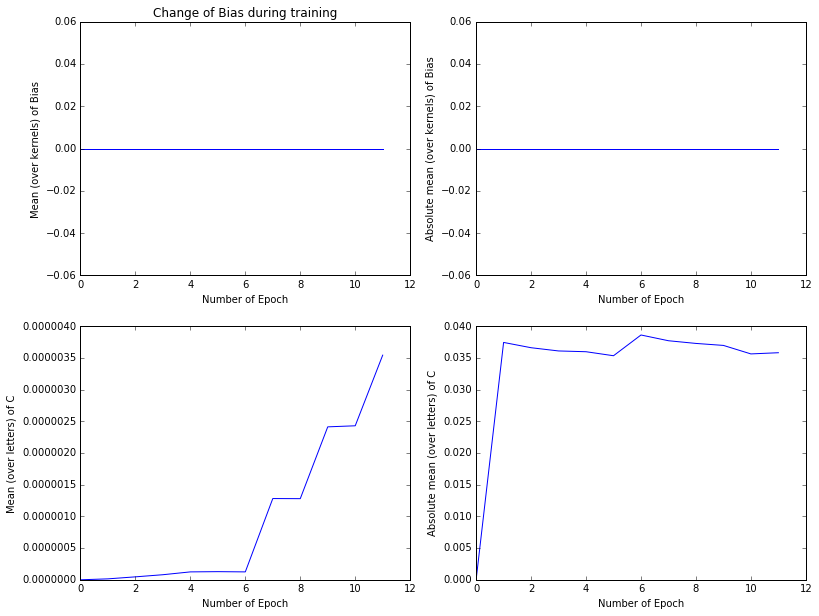

In [15]:
%matplotlib inline

listOfBiasSum = []
listOfBiasSumAbs = []
listOfCSum = []
listOfCSumAbs = []

idx = getObserverIndex("parameter")
obsRef = learner.observers[idx]
for i in range(len(obsRef.scores)):
    listOfBiasSum.append(obsRef.scores[i][1].mean())
    listOfBiasSumAbs.append(np.abs(obsRef.scores[i][1]).mean())
    listOfCSum.append(obsRef.scores[i][2].mean())
    listOfCSumAbs.append(np.abs(obsRef.scores[i][2]).mean())

fig = plt.figure(figsize=(13,10))

ax1 = fig.add_subplot(2,2,1)
ax1.set_xlabel('Number of Epoch')
ax1.set_title('Change of Bias during training')
ax1.set_ylabel('Mean (over kernels) of Bias')
ax1.plot(listOfBiasSum)

ax2 = fig.add_subplot(2,2,2)
ax2.set_xlabel('Number of Epoch')
ax2.set_ylabel('Absolute mean (over kernels) of Bias')
ax2.plot(listOfBiasSumAbs)

ax3 = fig.add_subplot(2,2,3)
ax3.set_xlabel('Number of Epoch')
ax3.set_ylabel('Mean (over letters) of C')
ax3.plot(listOfCSum)

ax4 = fig.add_subplot(2,2,4)
ax4.set_xlabel('Number of Epoch')
ax4.set_ylabel('Absolute mean (over letters) of C')
ax4.plot(listOfCSumAbs)

fig.savefig(modelDir + '/biasDevelopment.png', dpi=600)

(12, 4)


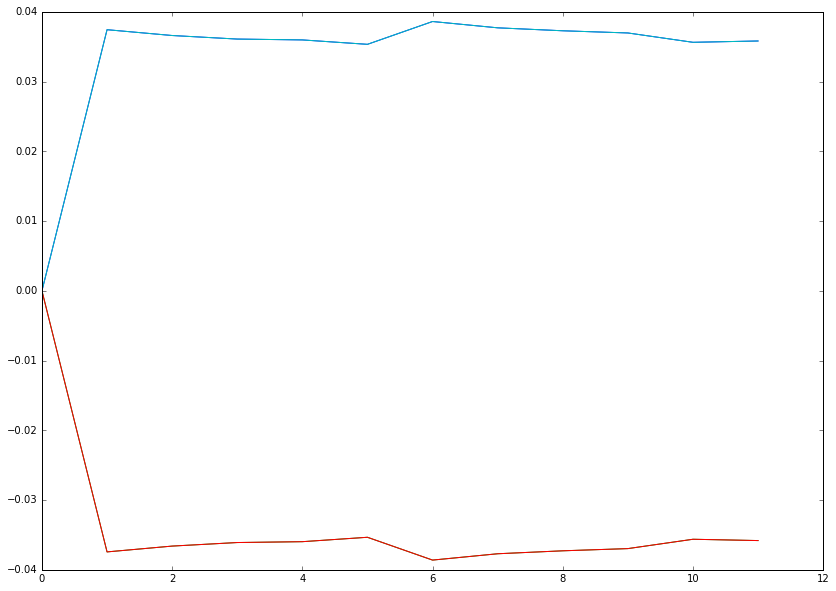

In [16]:
fig = plt.figure(figsize=(14,10))
cs = np.array([i[2] for i in obsRef.scores])
cs = cs.sum(axis=1)
print cs.shape
#cs = cs.reshape(cs.shape[0],4)
for i in range(4):
    plt.plot(cs[:,i])

(12, 1, 40)


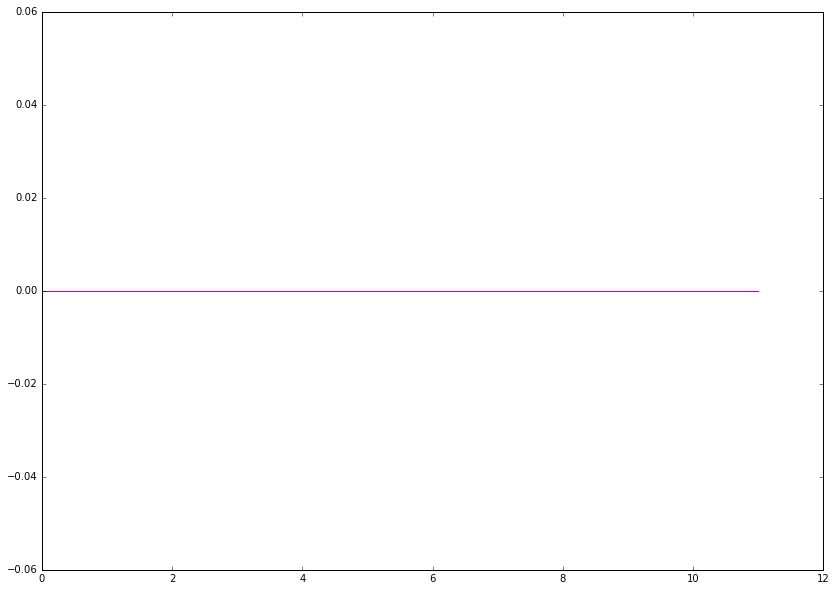

In [17]:
fig = plt.figure(figsize=(14,10))
bs = np.array([i[1] for i in obsRef.scores])
print bs.shape
bs = bs.reshape(bs.shape[0],bs.shape[2])
for i in range(bs.shape[1]):
    plt.plot(bs[:,i])

## Plot the gradients as heat maps
This may aide in finding out what's going wrong during the learning.

Chose observer: Parameter Observer
15


<IPython.core.display.Javascript object>


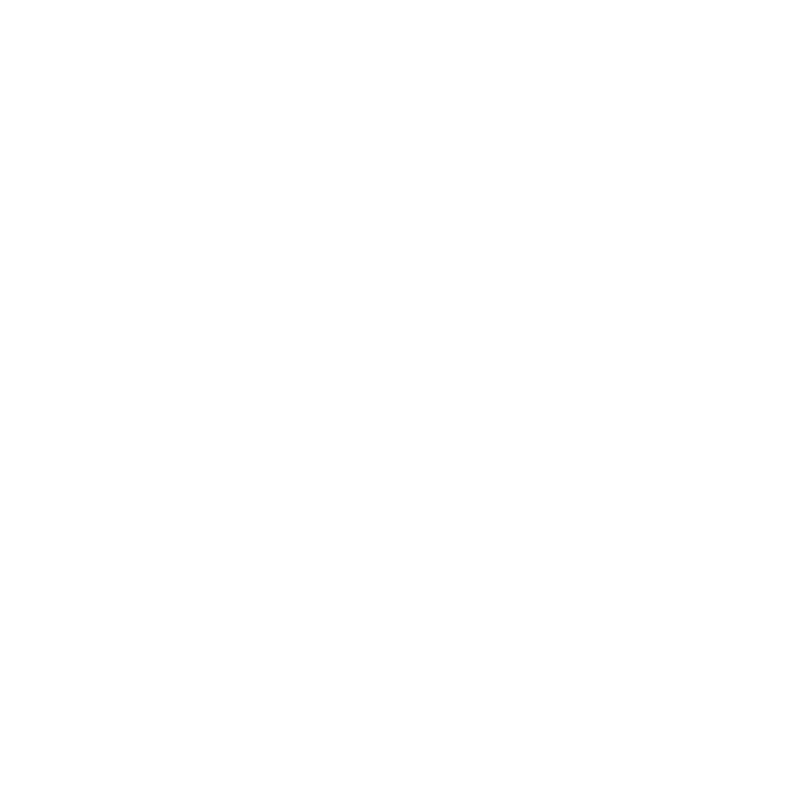

end of init with 60


AssertionError: 

<IPython.core.display.Javascript object>


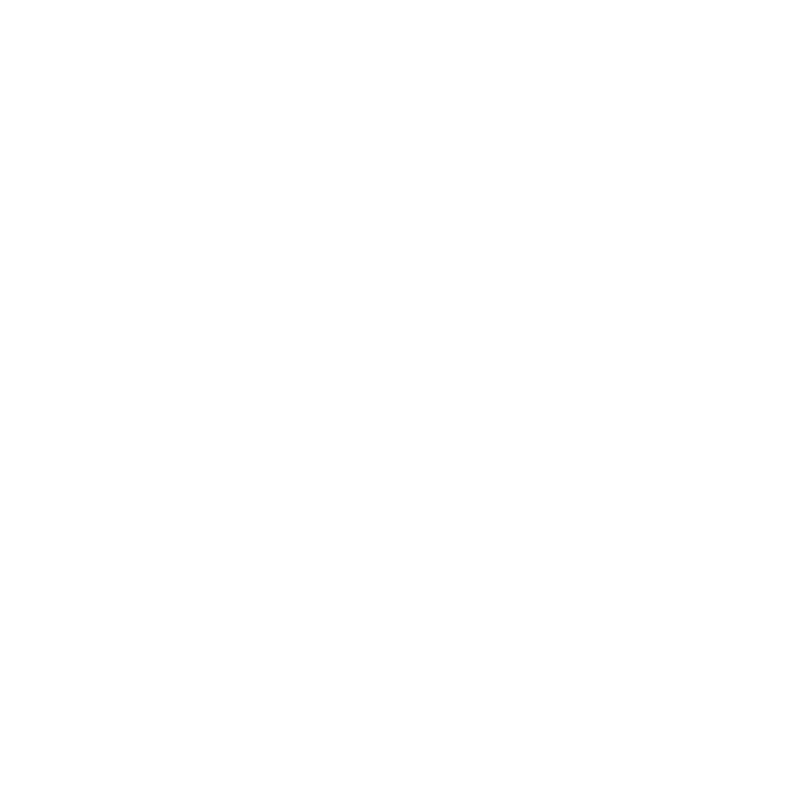

In [93]:
%matplotlib nbagg

import pprint
from matplotlib import animation

def getHeatmapFrom2DMat(matrix):
    plt.pcolor(matrix[::-1,:], cmap=plt.cm.Blues)
    plt.colorbar()
    print pprint.pprint(matrix)

observerIdx = getObserverIndex("parameter")
obsRef = learner.observers[observerIdx]
numberOfEpochs = 300
frames = min(len(obsRef.scores), numberOfEpochs)
print frames

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
x, y = bestSplit(obsRef.scores[0][0].shape[0])
frame_text = fig.text(0.95, 0.95,
                      'Epoch: ' + str(0),
                      verticalalignment='bottom',
                      horizontalalignment='right',
                      color='green', fontsize=30)

axesList = []
def initHeatmaps():
    allDiffsZero = np.abs(obsRef.scores[1][0] - obsRef.scores[0][0])
    for i in range(allDiffsZero.shape[0]):
        ax = fig.add_subplot(x, y, i+1, xticks=[], yticks=[])
        im = ax.pcolorfast(allDiffsZero[i,0,::-1,:],cmap=plt.cm.Blues)
        axesList.append(im)
    print "end of init with " + str(len(axesList))

def plotGradientForFrame(frameNr):
    assert frameNr < len(obsRef.scores)-1
    allDiffsPerEpoch = np.abs(obsRef.scores[frameNr+1][0] - obsRef.scores[frameNr][0])
    for motif in range(allDiffsPerEpoch.shape[0]):
        axesList[motif].set_data(allDiffsPerEpoch[motif,0,::-1,:])
    frame_text.set_text('Epoch: ' + str(frameNr))


anim = animation.FuncAnimation(fig,
                               plotGradientForFrame,
                               init_func=initHeatmaps,
                               frames=frames,
                               interval=20, repeat=False)
anim.save(modelDir + '/derivativeChanges.mp4', fps=10)

## Plot the motifs for one specific epoch
This is similar to the motif generation but only for one frame instead of a whole video.

Chose observer: Parameter Observer
6.0 7.0


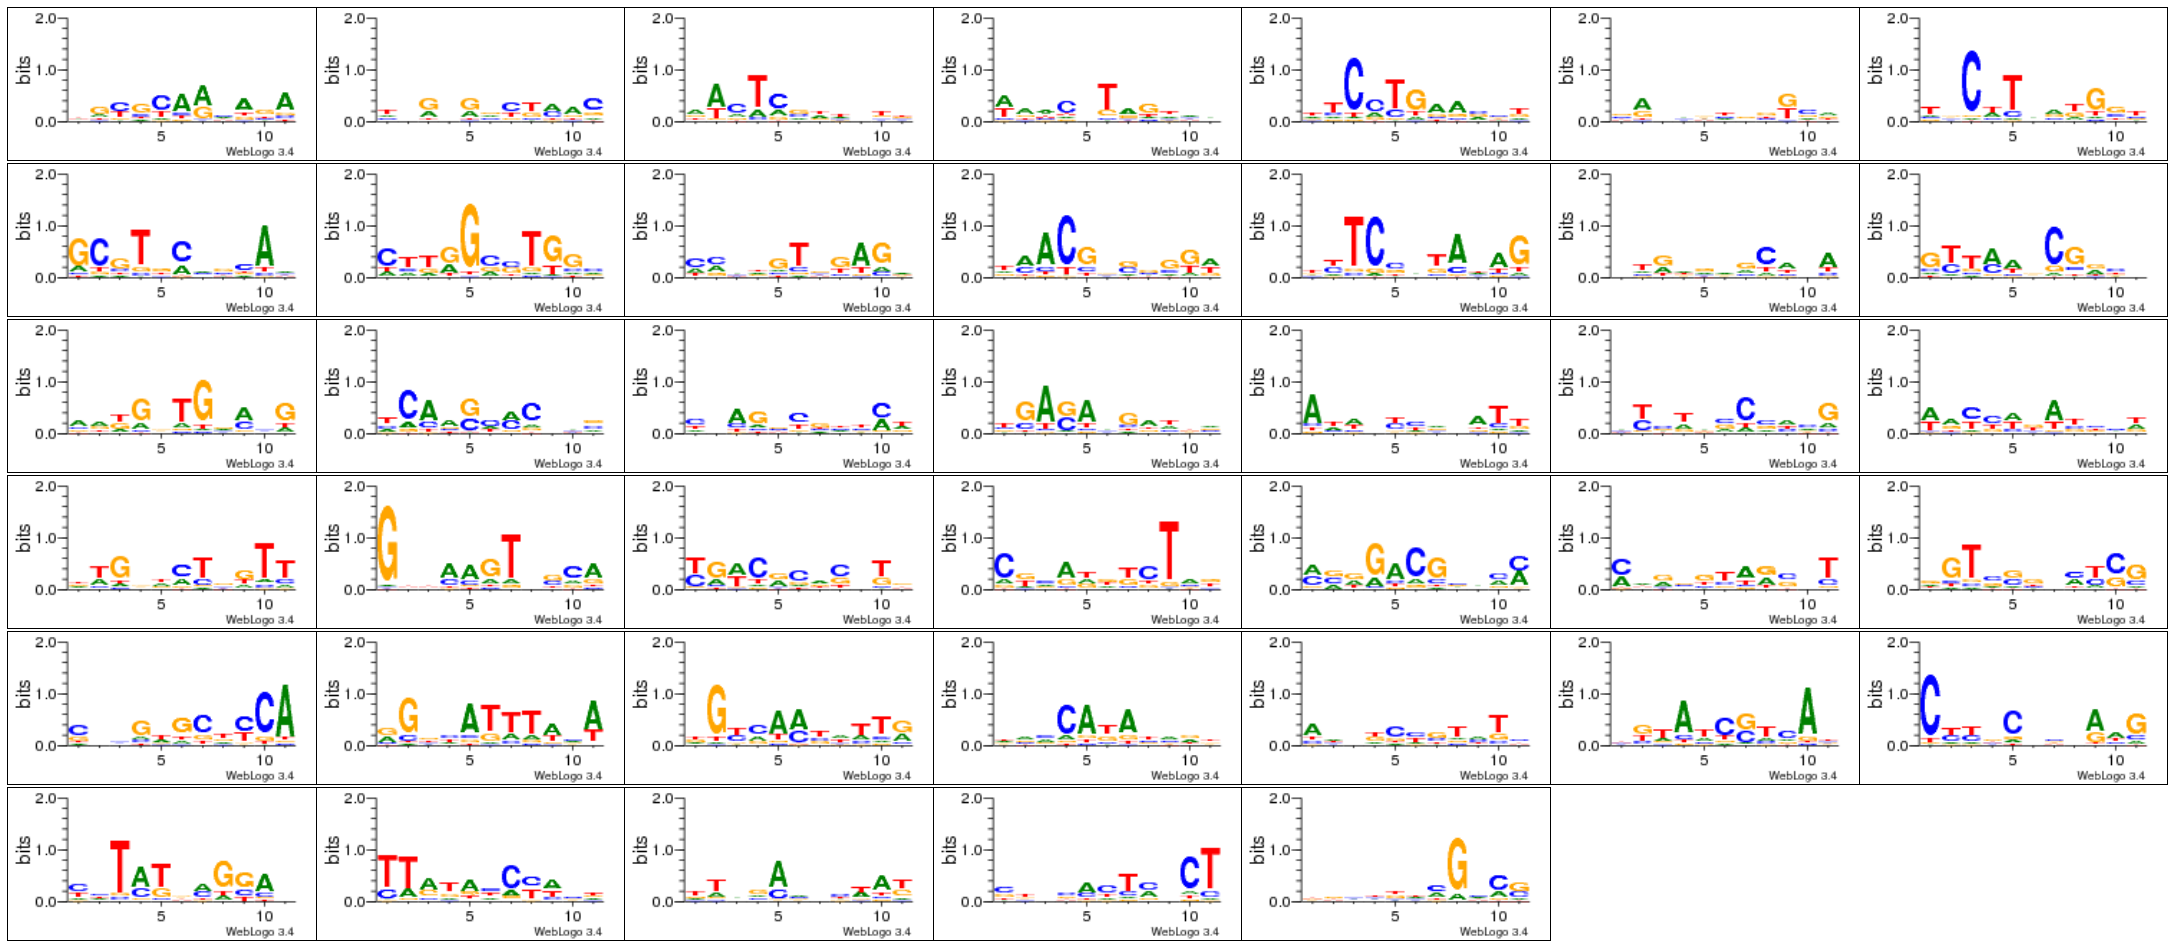

In [18]:
% matplotlib inline
observerIndex = getObserverIndex("parameter")
fig = plt.figure(figsize=(30,13))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
x, y = bestSplit(learner.observers[observerIndex].scores[0][0].shape[0])
print x, y

def showFrame(frameNr):
    allMotifsForFrame = learner.observers[observerIndex].scores[frameNr][0]
    cForFrame = learner.observers[observerIndex].scores[frameNr][2].reshape(-1)
    logos = getLogoListFrom4DMatrix(allMotifsForFrame, cForFrame)
    for motif in range(allMotifsForFrame.shape[0]):
        ax = fig.add_subplot(x, y, motif+1, xticks=[], yticks=[])
        ax.imshow(logos[motif])
    plt.savefig(modelDir + '/learnedMotif' + str(frameNr) + '.png')
showFrame(len(learner.observers[observerIndex].scores)-1)
showFrame(0)

## Make a video from the motifs in which we have a subplot of all motifs per frame!
For that, we have to find out how we can simply get the image without writing it to disk first.
Then, we can use python multimedia capabilities for some nice plotting!

In [29]:
# get the logos for all scores during training
observerIndex = getObserverIndex("parameter")
logosOverTime = []
numberOfEpochs = 50
numberOfEpochs = min(numberOfEpochs, len(learner.observers[observerIndex].scores))
frames = min(len(learner.observers[observerIndex].scores), numberOfEpochs)
for timeSlice in range(frames):
    allMotifsPerSlice = learner.observers[observerIndex].scores[timeSlice][0]
    cForSlice = learner.observers[observerIndex].scores[timeSlice][2]
    logosOverTime.append(getLogoListFrom4DMatrix(allMotifsPerSlice, cForSlice))
    print "Got Logos for Time/Epoch " + str(timeSlice)

Chose observer: Parameter Observer


KeyboardInterrupt: 

<IPython.core.display.Javascript object>


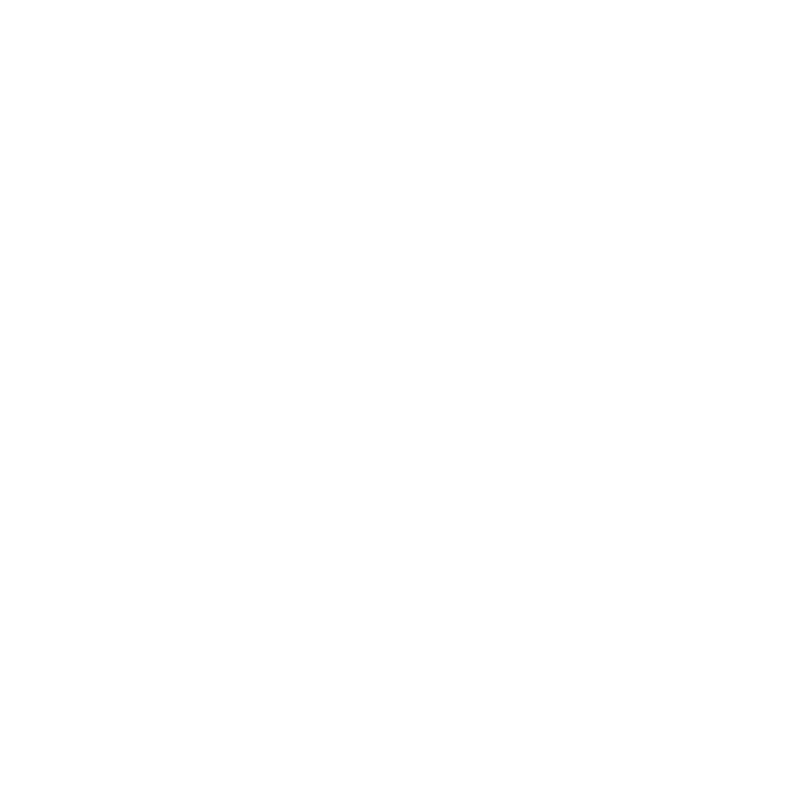

5.0 6.0
in init
30


<IPython.core.display.Javascript object>


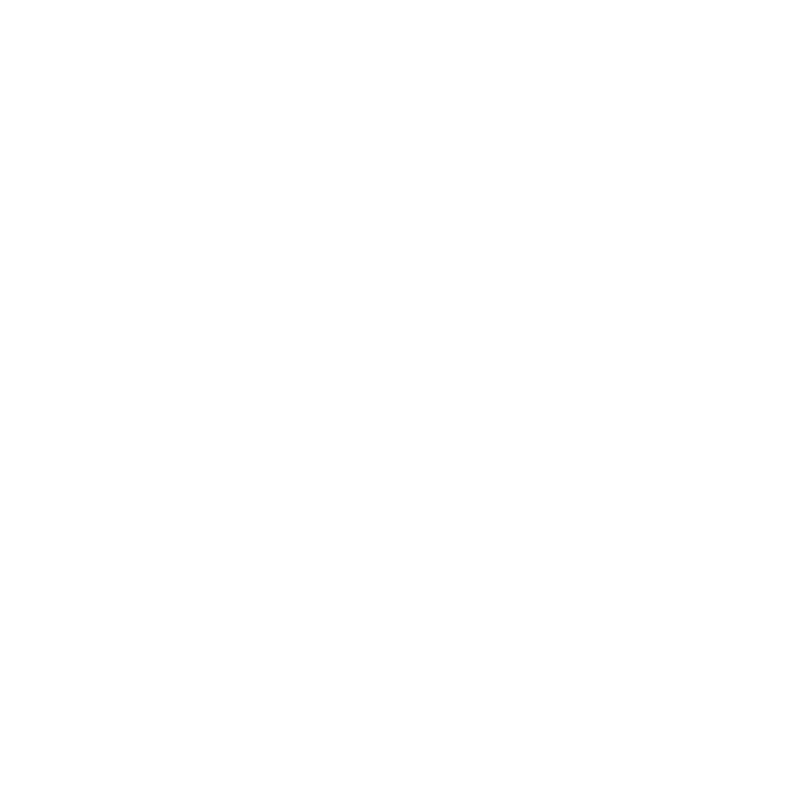

In [42]:
%matplotlib nbagg
from matplotlib import animation

fig = plt.figure(figsize=(10,10))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
frame_text = fig.text(0.95, 0.95,
                      'Epoch: ' + str(0),
                      verticalalignment='bottom',
                      horizontalalignment='right',
                      color='green', fontsize=30)

x, y = bestSplit(len(logosOverTime[0]))
print x, y
axesList = []

def init():
    print "in init"
    for i in range(len(logosOverTime[0])):
        ax = fig.add_subplot(x, y, i+1, xticks=[], yticks=[])
        im = ax.imshow(logosOverTime[0][i])
        axesList.append(im)
    print len(axesList)
        
def printFrame(frameNr):
    numMotifs = len(logosOverTime[frameNr])
    for motif in range(numMotifs):
        axesList[motif].set_data(logosOverTime[frameNr][motif])
        #ax.imshow(logosOverTime[frameNr][motif])
    frame_text.set_text('Epoch: ' + str(frameNr))

anim = animation.FuncAnimation(fig,
                               printFrame,
                               init_func=init,
                               frames=frames,
                               interval=1000, repeat=True)
anim.save(modelDir + '/motifChanges.mp4', fps=2)
#plt.show()

## Plot heat maps for gradients

Chose observer: Parameter Observer


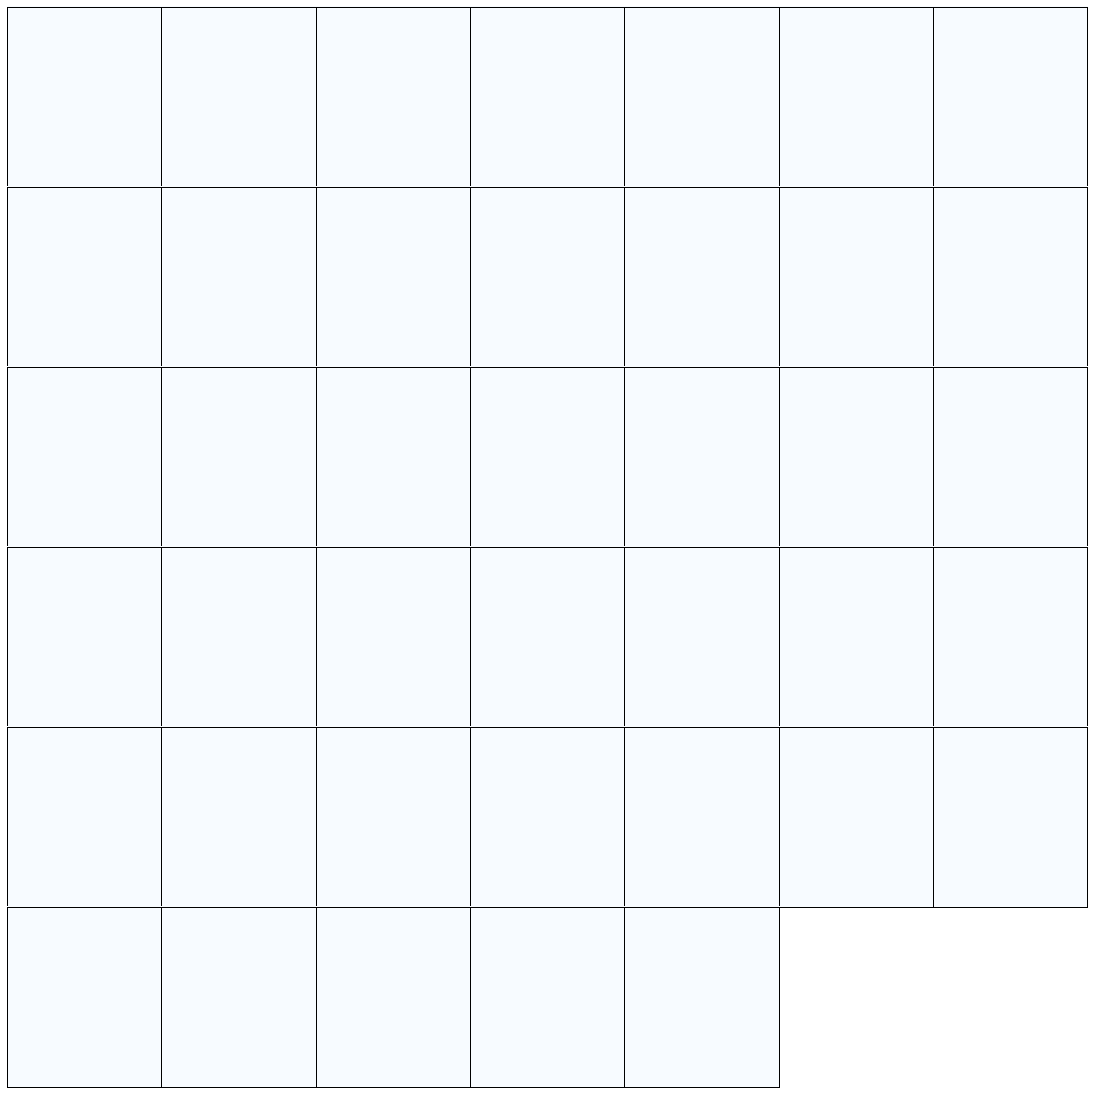

In [27]:
%matplotlib inline
fig = plt.figure(figsize=(15,15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)
#x, y = bestSplit(obsRef.scores[0][0].shape[0])
observerIdx = getObserverIndex("parameter")
def plotGradientForFrame(frameNr):
    assert frameNr < len(learner.observers[observerIdx].scores)-1
    allDiffsPerEpoch = learner.observers[observerIdx].scores[frameNr+1][0] - learner.observers[observerIdx].scores[frameNr][0]
    for motif in range(allDiffsPerEpoch.shape[0]):
        ax = fig.add_subplot(x,y,motif+1, xticks=[], yticks=[])
        ax.pcolorfast(allDiffsPerEpoch[motif,0], cmap=plt.cm.Blues)
    #plt.colorbar()
    
plotGradientForFrame(len(learner.observers[0].scores)-2)
plt.show()

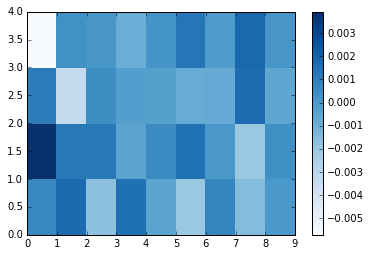

In [74]:
%matplotlib inline
frameNr = 100
allDiffsPerEpoch = learner.observers[observerIdx].scores[frameNr+1][0] - learner.observers[observerIdx].scores[frameNr][0]
plt.pcolor(allDiffsPerEpoch[4,0], cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

In [18]:
% matplotlib inline

obsFETrain = learner.observers[getObserverIndex("Free Energy Training")]
obsFETest = learner.observers[getObserverIndex("Free Energy Testing")]

obsRETrain = learner.observers[getObserverIndex("Reconstruction Rate Training")]
obsRETest = learner.observers[getObserverIndex("Reconstruction Rate Testing")]

fig = plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.ylabel('Free energy function')
#plt.title(str(hyper_params['learning_rate']) + " lr " + str(motif_length) + " kmers " + str(number_of_motifs) + " motifs_CD "+str(cd_k)+".png")

plt.plot(obsFETest.scores)
plt.plot(obsFETrain.scores)

plt.subplot(2,1,2)
plt.ylabel('Reconstruction rate on dataset')
plt.xlabel('Number Of Epoch')
plt.plot(obsRETest.scores)
plt.plot(obsRETrain.scores)

plt.savefig(modelDir + '/errorPlot.png', dpi=600)

Chose observer: Free Energy Training Observer
Chose observer: Free Energy Testing Observer


TypeError: list indices must be integers, not NoneType

Chose observer: Parameter Observer
Initial Motif
[[ 0.09  0.06  0.18  0.12  0.18  0.11]
 [ 0.5   0.29  0.04  0.37  0.49  0.27]
 [ 0.16  0.03  0.17  0.19  0.25  0.56]
 [ 0.25  0.63  0.6   0.32  0.08  0.06]]
Trained Motif
[[ 1.  1.  1.  1.  1.  1.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


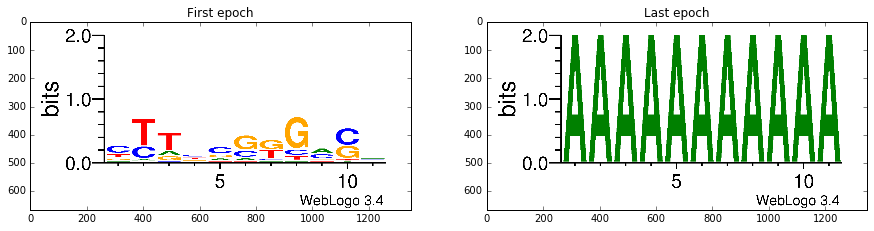

In [83]:
% matplotlib inline
from cStringIO import StringIO

def softmax(x):
    x_exp = np.exp(x)
    y = np.zeros(x.shape)
    for i in range(x.shape[1]):
        y[:,i] = x_exp[:,i] / np.sum(x_exp[:,i])
    return y

def createWeblogo(pwm):
    alph = Alphabet('ACGT')
    weblogoData = LogoData.from_counts(alph, pwm.T)#, learner.c.get_value().reshape(-1))
    weblogoOptions = LogoOptions(color_scheme=classic)
    weblogoOptions.title = "PWM"
    weblogoFormat = LogoFormat(weblogoData, weblogoOptions)
    x = png_print_formatter(weblogoData, weblogoFormat)
    fake_file = StringIO(x)
    return plt.imread(fake_file)

obsRef = learner.observers[getObserverIndex("parameter")]
t1 = obsRef.scores[0][0][0,0]
s1 = softmax(t1)
print "Initial Motif"
print s1[:,:6]
fig = plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.imshow(createWeblogo(s1))
plt.title('First epoch')

plt.subplot(1,2,2)
t2 = obsRef.scores[len(obsRef.scores)-1][0][0,0]
s2 = softmax(t2)
print "Trained Motif"
print s2[:,:6]
plt.imshow(createWeblogo(s2))
plt.title('Last epoch')
plt.show()

In [30]:
print len(obsRef.scores)
print obsRef.scores[99][0][0,0][:,:5]
print obsRef.scores[0][0][0,0][:,:5]

101
[[-0.32696527 -0.52348667  0.47141385 -0.13623776  0.31638721]
 [-0.73379374  0.40430894  0.86032677 -0.47208509 -0.29405341]
 [-1.73040462 -0.13017678 -0.5276767  -0.26112044 -0.91058427]
 [ 0.35293186  0.87320483  0.52439457  0.8815046  -1.0187881 ]]
[[-0.02320542 -0.89363432  0.45808777 -0.02209563  0.65885133]
 [-1.12001812  0.45115328  0.99284458 -0.58178246 -0.59416038]
 [-2.04848361 -0.21796398 -1.03131378 -0.00379665 -0.75867403]
 [ 0.70788676  1.23869789  0.86321765  0.57414371 -1.25863159]]
